# Description
### COVID-19 Detection using Chest Xray
As you probably know, we are in the tight hold of a pandemic which has its disastarous effect on this world. We are standing together even while physically distancing ourselves, protecting others and caring for others in this dreadful times. Humanity still deserved to live for million years. But we should contribute our role in this fight against an invisible enemy.

Many Data Scientist are working getting predictions and developing models for strategies. We can assist HealthCare workers and Doctors by developing a AI Assistment or Model. A Image Classification model can handle a lot of worries for Doctors, especially in X Ray Diagnosis.

In this notebook, I am going to train a CNN classifier which can classify COVID-19 Infected Lung Xray images from Healthy Lung Xray images. For that we need dataset from both classes, I used the dataset from two sources,

Cohen's COVID Chest X-ray Dataset


Paul Mooney's Chest X-ray Dataset (Pneumonia)



In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.utils.data as data

from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil
from google.colab import drive
drive.mount('/content/drive')

PATH="your path"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset preprocessing
 covid data -> https://github.com/ieee8023/covid-chestxray-dataset.git

In [ ]:
#!git clone https://github.com/ieee8023/covid-chestxray-dataset.git
df = pd.read_csv(PATH+'./covid-chestxray-dataset/metadata.csv')
selected_df = df[df.finding=="Pneumonia/Viral/COVID-19"]
selected_df = selected_df[(selected_df.view == "AP") | (selected_df.view == "PA")]
selected_df.head(2)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [ ]:
import os
!pip install kaggle

os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file


!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia/data # api copied from kaggle

In [ ]:
!unzip -o ./chest-xray-pneumonia.zip

In [ ]:
os.remove('chest-xray-pneumonia.zip')

In [ ]:

isExist = os.path.exists(PATH+'./COVID19-DATASET/normal')
if not isExist:
   os.makedirs(PATH+'./COVID19-DATASET/normal')
isExist = os.path.exists(PATH+'./COVID19-DATASET/covid19')
if not isExist:
   os.makedirs(PATH+'./COVID19-DATASET/covid19')

images = selected_df.filename.values.tolist()

COVID_PATH = PATH+'./COVID19-DATASET/covid19'
NORMAL_PATH = PATH+'./COVID19-DATASET/normal'

#copy covid-19 image from "covid-chestxray-dataset"
for image in images:
    shutil.copy(os.path.join(PATH+'./covid-chestxray-dataset/images', image), os.path.join(COVID_PATH, image))

#copy normal image from "chest_xray_pneumonia"
for image in os.listdir(PATH+'./chest_xray_pneumonia/train/NORMAL')[:300]:
    shutil.copy(os.path.join(PATH+'./chest_xray_pneumonia/train/NORMAL', image), os.path.join(NORMAL_PATH, image))

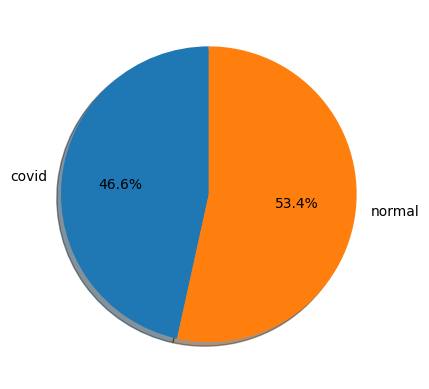

In [ ]:
DATA_PATH = PATH  +'./COVID19-DATASET'
COVID_PATH = PATH +'./COVID19-DATASET/covid19'
NORMAL_PATH = PATH +'./COVID19-DATASET/normal'


class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

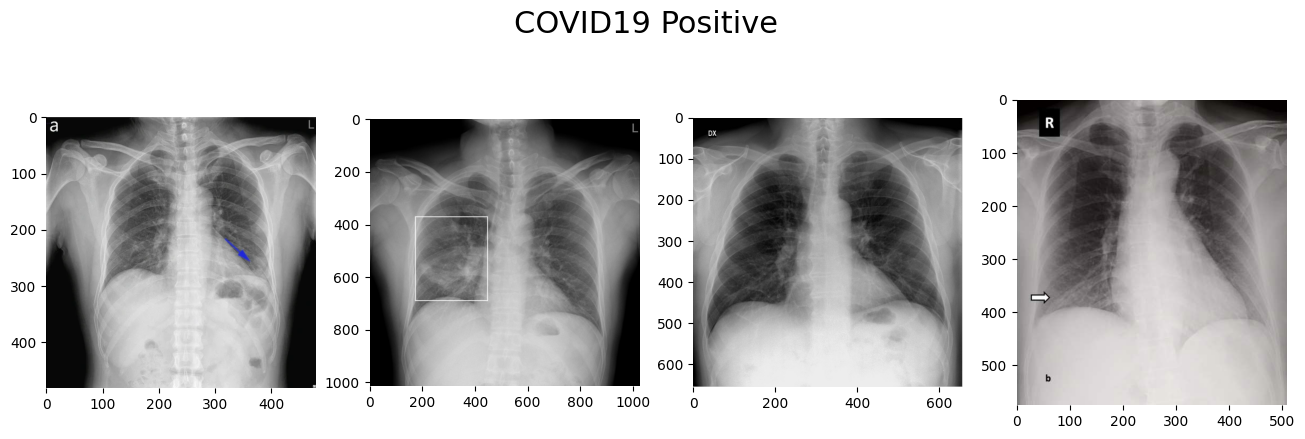

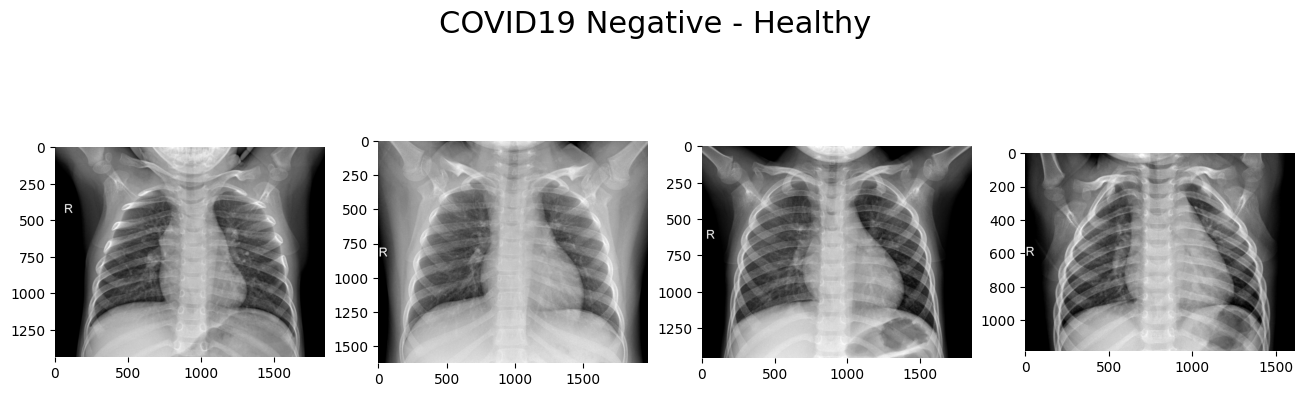

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "test": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}



train_data = datasets.ImageFolder(DATA_PATH,
                transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
test_data = datasets.ImageFolder(DATA_PATH,
                transform=data_transforms['test'])


num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(.2 * num_train))

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]


print('TRAIN:',len(train_idx))
print('VAL:',len(val_idx))


TRAIN: 337
VAL: 84


In [ ]:
len(train_data)

421

In [ ]:

train_data, test_data,valid_data = data.random_split(train_data,
                                           [337, 42,42])

In [ ]:

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8) # DataLoader provides data from traininng and validation in batches
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)


print('TRAIN:',len(trainloader))
print('VAL:',len(val_loader))

print('Test:',len(test_loader))



dataloaders = {"train":trainloader, "val":val_loader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
data_sizes

TRAIN: 43
VAL: 6
Test: 6


{'train': 337, 'val': 42}

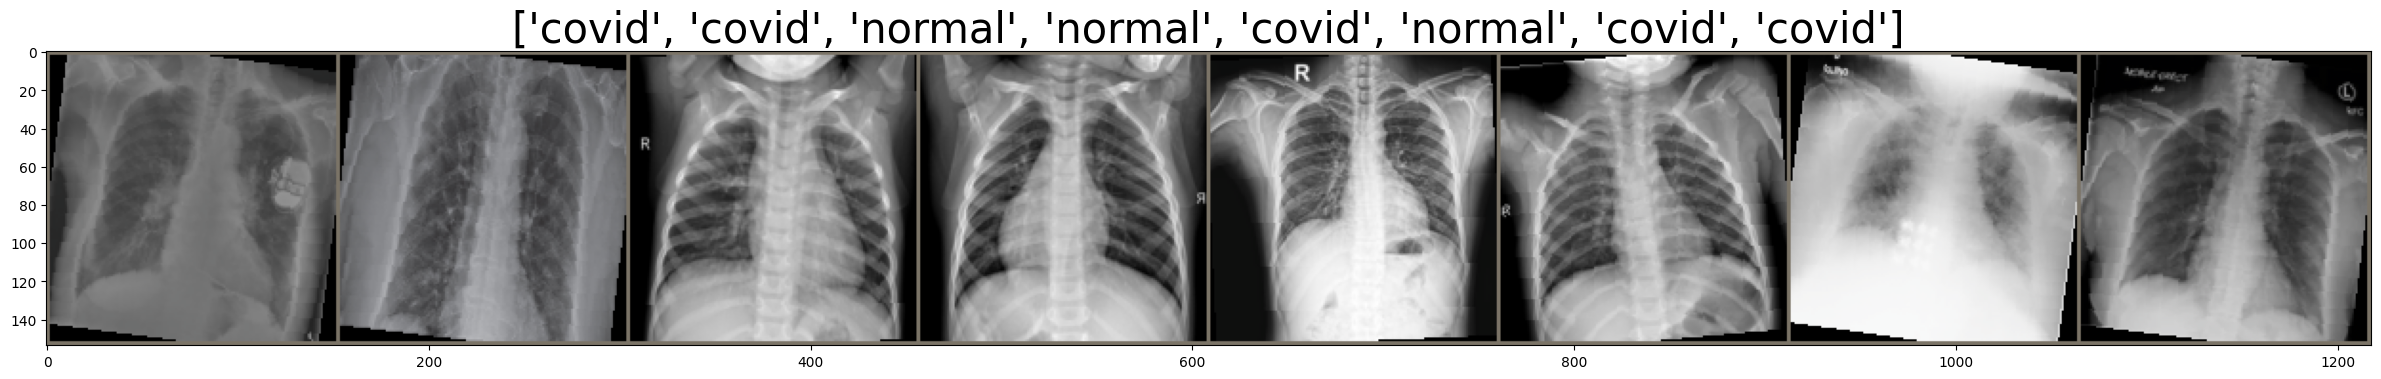

In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU..")
else:
    device = torch.device("cpu")
    print("Training on CPU...")

Training on GPU..


## Model Definition


In [ ]:
def CNN_Model(pretrained=True):
    model = models.mobilenet_v2(pretrained=pretrained) # Returns Defined mobilenet_v2 model with weights trained on ImageNet

    num_ftrs = model.classifier[1].in_features # Get the number of features output from CNN layer


    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 
2226434


## test the model

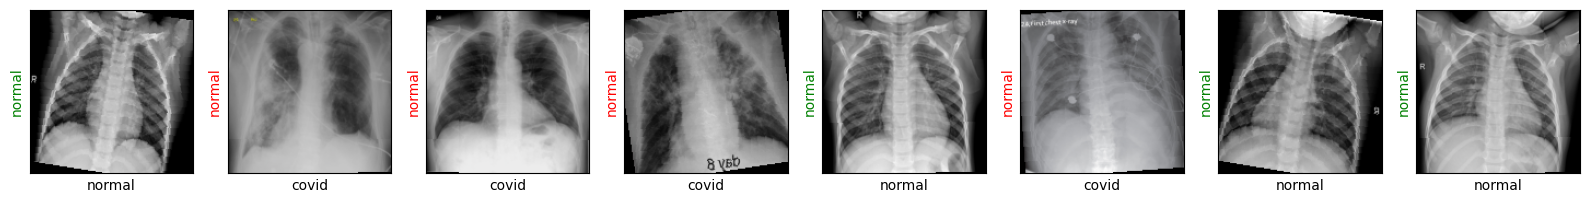

In [ ]:

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 8, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

def show_preds(DATA_LOADER):
    model.eval()
    images, labels = next(iter(DATA_LOADER))
    outputs  = model(images.to(device))
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels, preds.cpu())
show_preds(test_loader)


# Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))

            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Epoch 1/10
----------


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.3642 | train Accuracy: 0.9050


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0227 | val Accuracy: 1.0000 | Kappa Score: nan
Val loss Decreased from inf to 0.0227 
Saving Weights... 

Epoch 2/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2574 | train Accuracy: 0.9139


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0519 | val Accuracy: 0.9524 | Kappa Score: nan

Epoch 3/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2219 | train Accuracy: 0.9258


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0284 | val Accuracy: 0.9762 | Kappa Score: nan

Epoch 4/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2480 | train Accuracy: 0.9466


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0378 | val Accuracy: 0.9762 | Kappa Score: nan

Epoch 5/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2184 | train Accuracy: 0.9436


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0342 | val Accuracy: 0.9762 | Kappa Score: nan

Epoch 6/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2168 | train Accuracy: 0.9318


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0174 | val Accuracy: 1.0000 | Kappa Score: nan
Val loss Decreased from 0.0227 to 0.0174 
Saving Weights... 

Epoch 7/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2224 | train Accuracy: 0.9318


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0293 | val Accuracy: 1.0000 | Kappa Score: nan

Epoch 8/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2467 | train Accuracy: 0.9258


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0214 | val Accuracy: 1.0000 | Kappa Score: nan

Epoch 9/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2078 | train Accuracy: 0.9377


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0420 | val Accuracy: 0.9762 | Kappa Score: nan

Epoch 10/10
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/43 [00:00<?, ?it/s]

train Loss: 0.2398 | train Accuracy: 0.9377


val:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0140 | val Accuracy: 1.0000 | Kappa Score: nan
Val loss Decreased from 0.0174 to 0.0140 
Saving Weights... 

Training complete in 2m 42s
Best val loss: 0.0140


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

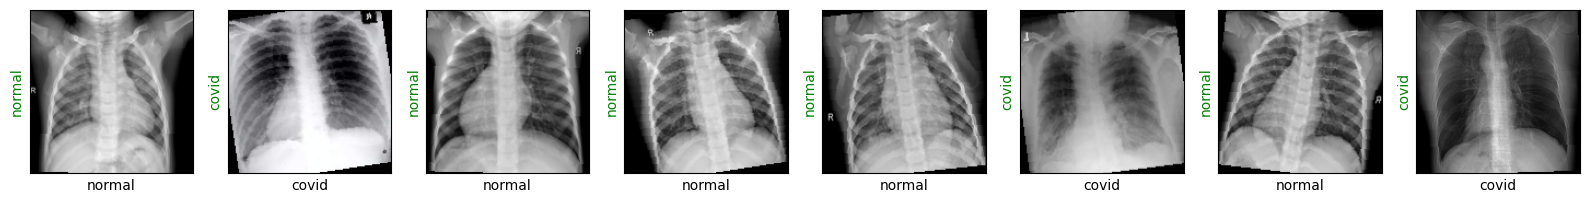

In [ ]:
def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 8, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

def show_preds(DATA_LOADER):
    model.eval()
    images, labels = next(iter(DATA_LOADER))
    outputs  = model(images.to(device))
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels, preds.cpu())
show_preds(dataloaders["val"])


# model Evauation

In [ ]:
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(test_loader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)

        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)

        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
y_pred_list=np.hstack(y_pred_list)
y_true_list=np.hstack(y_true_list)
print(classification_report(y_true_list, y_pred_list,target_names=["COVID-19","Normal"]))

  0%|          | 0/6 [00:00<?, ?it/s]

[1 0 0 0 1 0 1 1]
[0 0 1 1 1 1 1 0]
[1 0 1 0 1 0 1 1]
[0 0 1 0 1 1 1 1]
[1 0 1 0 0 1 1 1]
[0 1]
              precision    recall  f1-score   support

    COVID-19       0.94      1.00      0.97        17
      Normal       1.00      0.96      0.98        25

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

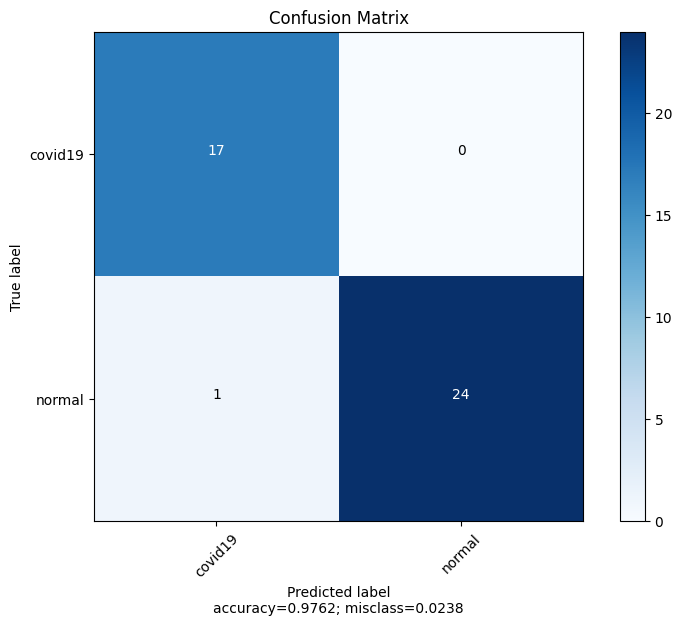

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")